In [241]:
import pandas as pd
import os

# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))

In [242]:
df['genre'] = df['genre'].apply(lambda x: x.split(',') if pd.notna(x) else x)
# clean genre column from [, ], '
df['genre'] = df['genre'].apply(
    lambda x: [i.strip().replace("'", "").replace("[", "").replace("]", "") for i in x] if isinstance(x, list) else x
)
df['genre']

0               [Adventure, Sci-Fi]
1           [Crime, Drama, Romance]
2              [Documentary, Music]
3       [Action, Adventure, Sci-Fi]
4        [Adventure, Comedy, Drama]
                   ...             
1129    [Horror, Mystery, Thriller]
1130     [Biography, Comedy, Drama]
1131     [Comedy, Horror, Thriller]
1132    [Biography, Drama, History]
1133     [Biography, Comedy, Drama]
Name: genre, Length: 1134, dtype: object

In [243]:
# Compute frequency encoding for each genre
from collections import Counter
genre_counts = Counter(genre for sublist in df['genre'].dropna() for genre in sublist)
genre_freq = {genre: count / len(df) for genre, count in genre_counts.items()}

genre_freq

{'Adventure': 0.31569664902998235,
 'Sci-Fi': 0.08818342151675485,
 'Crime': 0.13051146384479717,
 'Drama': 0.48677248677248675,
 'Romance': 0.09700176366843033,
 'Documentary': 0.023809523809523808,
 'Music': 0.03439153439153439,
 'Action': 0.3165784832451499,
 'Comedy': 0.35978835978835977,
 'Fantasy': 0.07583774250440917,
 'Thriller': 0.14109347442680775,
 'History': 0.05555555555555555,
 'War': 0.010582010582010581,
 'Animation': 0.10493827160493827,
 'Biography': 0.13051146384479717,
 'Horror': 0.11199294532627865,
 'Mystery': 0.08818342151675485,
 'Family': 0.0582010582010582,
 'Sport': 0.021164021164021163,
 'Musical': 0.010582010582010581,
 'Short': 0.001763668430335097,
 'Western': 0.001763668430335097}

In [244]:
# convert genre column into genre1, genre2, genre3 columns, sorting on frequency
df['genre'] = df['genre'].apply(lambda x: sorted(x, key=lambda y: genre_freq.get(y, 0), reverse=True) if isinstance(x, list) else x)

genre_cols = ['genre1', 'genre2', 'genre3']

df[genre_cols] = pd.DataFrame(df['genre'].tolist(), index=df.index).iloc[:, :3]
df = df.drop(columns=['genre'])

In [245]:
# convert genre columns into frequency encoding
df['genre1'] = df['genre1'].map(genre_freq)
df['genre2'] = df['genre2'].map(genre_freq)
df['genre3'] = df['genre3'].map(genre_freq)

In [246]:
df = df.fillna(0)

df[genre_cols].head()

,genre1,genre2,genre3
0,0.315697,0.088183,0.000000
1,0.486772,0.130511,0.097002
2,0.034392,0.023810,0.000000
3,0.316578,0.315697,0.088183
4,0.486772,0.359788,0.315697


In [247]:
df.groupby('rating_category').size()

rating_category
High           377
Low             10
Medium         387
Medium High    232
Medium Low     128
dtype: int64

In [248]:
# merge Medium Low and Low into a single category
df['rating_category'] = df['rating_category'].replace({
    'Medium Low': 'Low'
})

In [249]:
# 80-20 stratified split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['rating_category'], random_state=42
)

# further split train into train and val
train_df, val_df = train_test_split(
    train_df, test_size=0.25, stratify=train_df['rating_category'], random_state=42
)

X_train = train_df.drop(columns=['id', 'rating', 'rating_category'])
y_train = train_df['rating_category']

X_val = val_df.drop(columns=['id', 'rating', 'rating_category'])
y_val = val_df['rating_category']

X_test = test_df.drop(columns=['id', 'rating', 'rating_category'])
y_test = test_df['rating_category']

In [250]:
# Log scale transformation only for columns '0', '1', ... '99' (TS columns)
import numpy as np

ts_columns = [str(i) for i in range(100)]
X_train[ts_columns] = X_train[ts_columns].applymap(lambda x: np.log1p(x))
X_val[ts_columns] = X_val[ts_columns].applymap(lambda x: np.log1p(x))
X_test[ts_columns] = X_test[ts_columns].applymap(lambda x: np.log1p(x))

/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_72262/1279882901.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train[ts_columns] = X_train[ts_columns].applymap(lambda x: np.log1p(x))
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_72262/1279882901.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_val[ts_columns] = X_val[ts_columns].applymap(lambda x: np.log1p(x))
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_72262/1279882901.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test[ts_columns] = X_test[ts_columns].applymap(lambda x: np.log1p(x))


In [251]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_val_enc = to_categorical(label_encoder.transform(y_val))
y_test_enc = to_categorical(label_encoder.transform(y_test))

In [252]:
# Split X into ts and genre
X_train = {
    'ts_1': X_train[:, :50].reshape(-1, 50, 1),
    'ts_2': X_train[:, 50:100].reshape(-1, 50, 1),
    'genre': X_train[:, 100:103]
}
X_val = {
    'ts_1': X_val[:, :50].reshape(-1, 50, 1),
    'ts_2': X_val[:, 50:100].reshape(-1, 50, 1),
    'genre': X_val[:, 100:103]
}
X_test = {
    'ts_1': X_test[:, :50].reshape(-1, 50, 1),
    'ts_2': X_test[:, 50:100].reshape(-1, 50, 1),
    'genre': X_test[:, 100:103]
}

In [253]:
from json import encoder
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Genre branch
genre_input = Input(shape=(3,), name='genre')
genre_branch = Dense(8, activation='relu')(genre_input)
genre_branch = BatchNormalization()(genre_branch)

# Encoder
encoder_input = Input(shape=(50, 1), name='ts_1')
encoder_branch = Bidirectional(LSTM(
    32,
    return_sequences=True,
    recurrent_dropout=0.3
))(encoder_input)
encoder_branch = BatchNormalization()(encoder_branch)
_, h_fwd, c_fwd, h_bwd, c_bwd = Bidirectional(LSTM(
    64,
    return_state=True,
    recurrent_dropout=0.3
))(encoder_branch)

# Decoder
decoder_input = Input(shape=(50, 1), name='ts_2')
decoder_branch = Bidirectional(LSTM(
    64,
    return_sequences=True,
    recurrent_dropout=0.3
))(decoder_input, initial_state=[h_fwd, c_fwd, h_bwd, c_bwd])
decoder_branch = BatchNormalization()(decoder_branch)
decoder_branch = Bidirectional(LSTM(
    32,
    return_sequences=False,
    recurrent_dropout=0.3
))(decoder_branch)
decoder_branch = BatchNormalization()(decoder_branch)


# Concatenate genre branch with decoder output
concatenated = Concatenate()([decoder_branch, genre_branch])
concatenated = Dense(64, activation='relu')(concatenated)
concatenated = BatchNormalization()(concatenated)
concatenated = Dropout(0.3)(concatenated)

output = Dense(4, activation='softmax')(concatenated)
model2 = Model(inputs=[encoder_input, decoder_input, genre_input], outputs=output)
model2.compile(optimizer=Adam(learning_rate=0.005), loss='categorical_crossentropy', metrics=['accuracy'])

In [254]:
from pyexpat import model
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

weights_2 = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

weights_2 = dict(enumerate(weights_2))

# Train the model
history_2 = model2.fit(
    X_train,
    y_train_enc,
    validation_data=(
        X_val,
        y_val_enc
    ),
    epochs=200,
    batch_size=32,
    verbose=1,
    class_weight=weights_2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            start_from_epoch=50
        )
    ]
)

Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.2936 - loss: 1.9818 - val_accuracy: 0.4185 - val_loss: 1.2985
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.3645 - loss: 1.4834 - val_accuracy: 0.4097 - val_loss: 1.2594
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3938 - loss: 1.3161 - val_accuracy: 0.3744 - val_loss: 1.2655
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4022 - loss: 1.2875 - val_accuracy: 0.3260 - val_loss: 1.3143
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.4073 - loss: 1.2178 - val_accuracy: 0.4361 - val_loss: 1.2478
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4395 - loss: 1.2034 - val_accuracy: 0.4361 - val_loss: 1.1869
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.3855 - loss: 1.2525 - val_accuracy: 0.4053 - val_loss: 1.1964
Epoch 8/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.4305 - loss: 1.2364 - val_accuracy: 

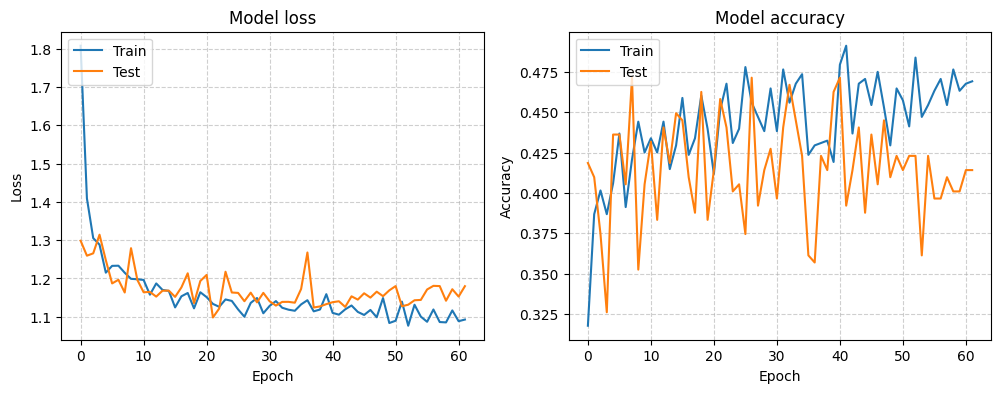

In [255]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [256]:
# evaluate the model
test_loss_2, test_accuracy_2 = model2.evaluate(
    X_test,
    y_test_enc,
    verbose=0
)

In [257]:
# sort the labels as Low, Medium, Medium High, High
labels = ['Low', 'Medium', 'Medium High', 'High']

# classification report
from sklearn.metrics import classification_report
print(f'Test Accuracy: {test_accuracy_2:.4f}')
y_pred_probs = model2.predict(
    X_test
)
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))
print(classification_report(y_test, y_pred, labels=labels))

Test Accuracy: 0.4581
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 255ms/step
              precision    recall  f1-score   support

         Low       0.36      0.61      0.45        28
      Medium       0.55      0.31      0.39        78
 Medium High       0.31      0.37      0.34        46
        High       0.57      0.61      0.59        75

    accuracy                           0.46       227
   macro avg       0.45      0.47      0.44       227
weighted avg       0.48      0.46      0.45       227



8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


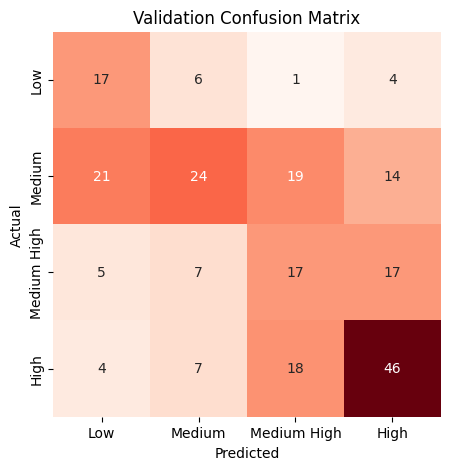

In [258]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming these variables are defined elsewhere in your notebook
# model2, val_scaled, label_encoder, y_val

# Predict on test set
test_pred_probs = model2.predict(
    X_test
)
test_pred = label_encoder.inverse_transform(np.argmax(test_pred_probs, axis=1))

# Compute sorted confusion matrix
# The key change is passing the `labels` variable directly to the function
cm_val = confusion_matrix(y_test, test_pred, labels=labels)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
# Sorted heatmap
# Another key change is setting xticklabels and yticklabels to the `labels` variable
sns.heatmap(
    cm_val, annot=True, fmt='d',
    xticklabels=labels,
    yticklabels=labels,
    cmap='Reds', cbar=False,
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Validation Confusion Matrix')
plt.show()

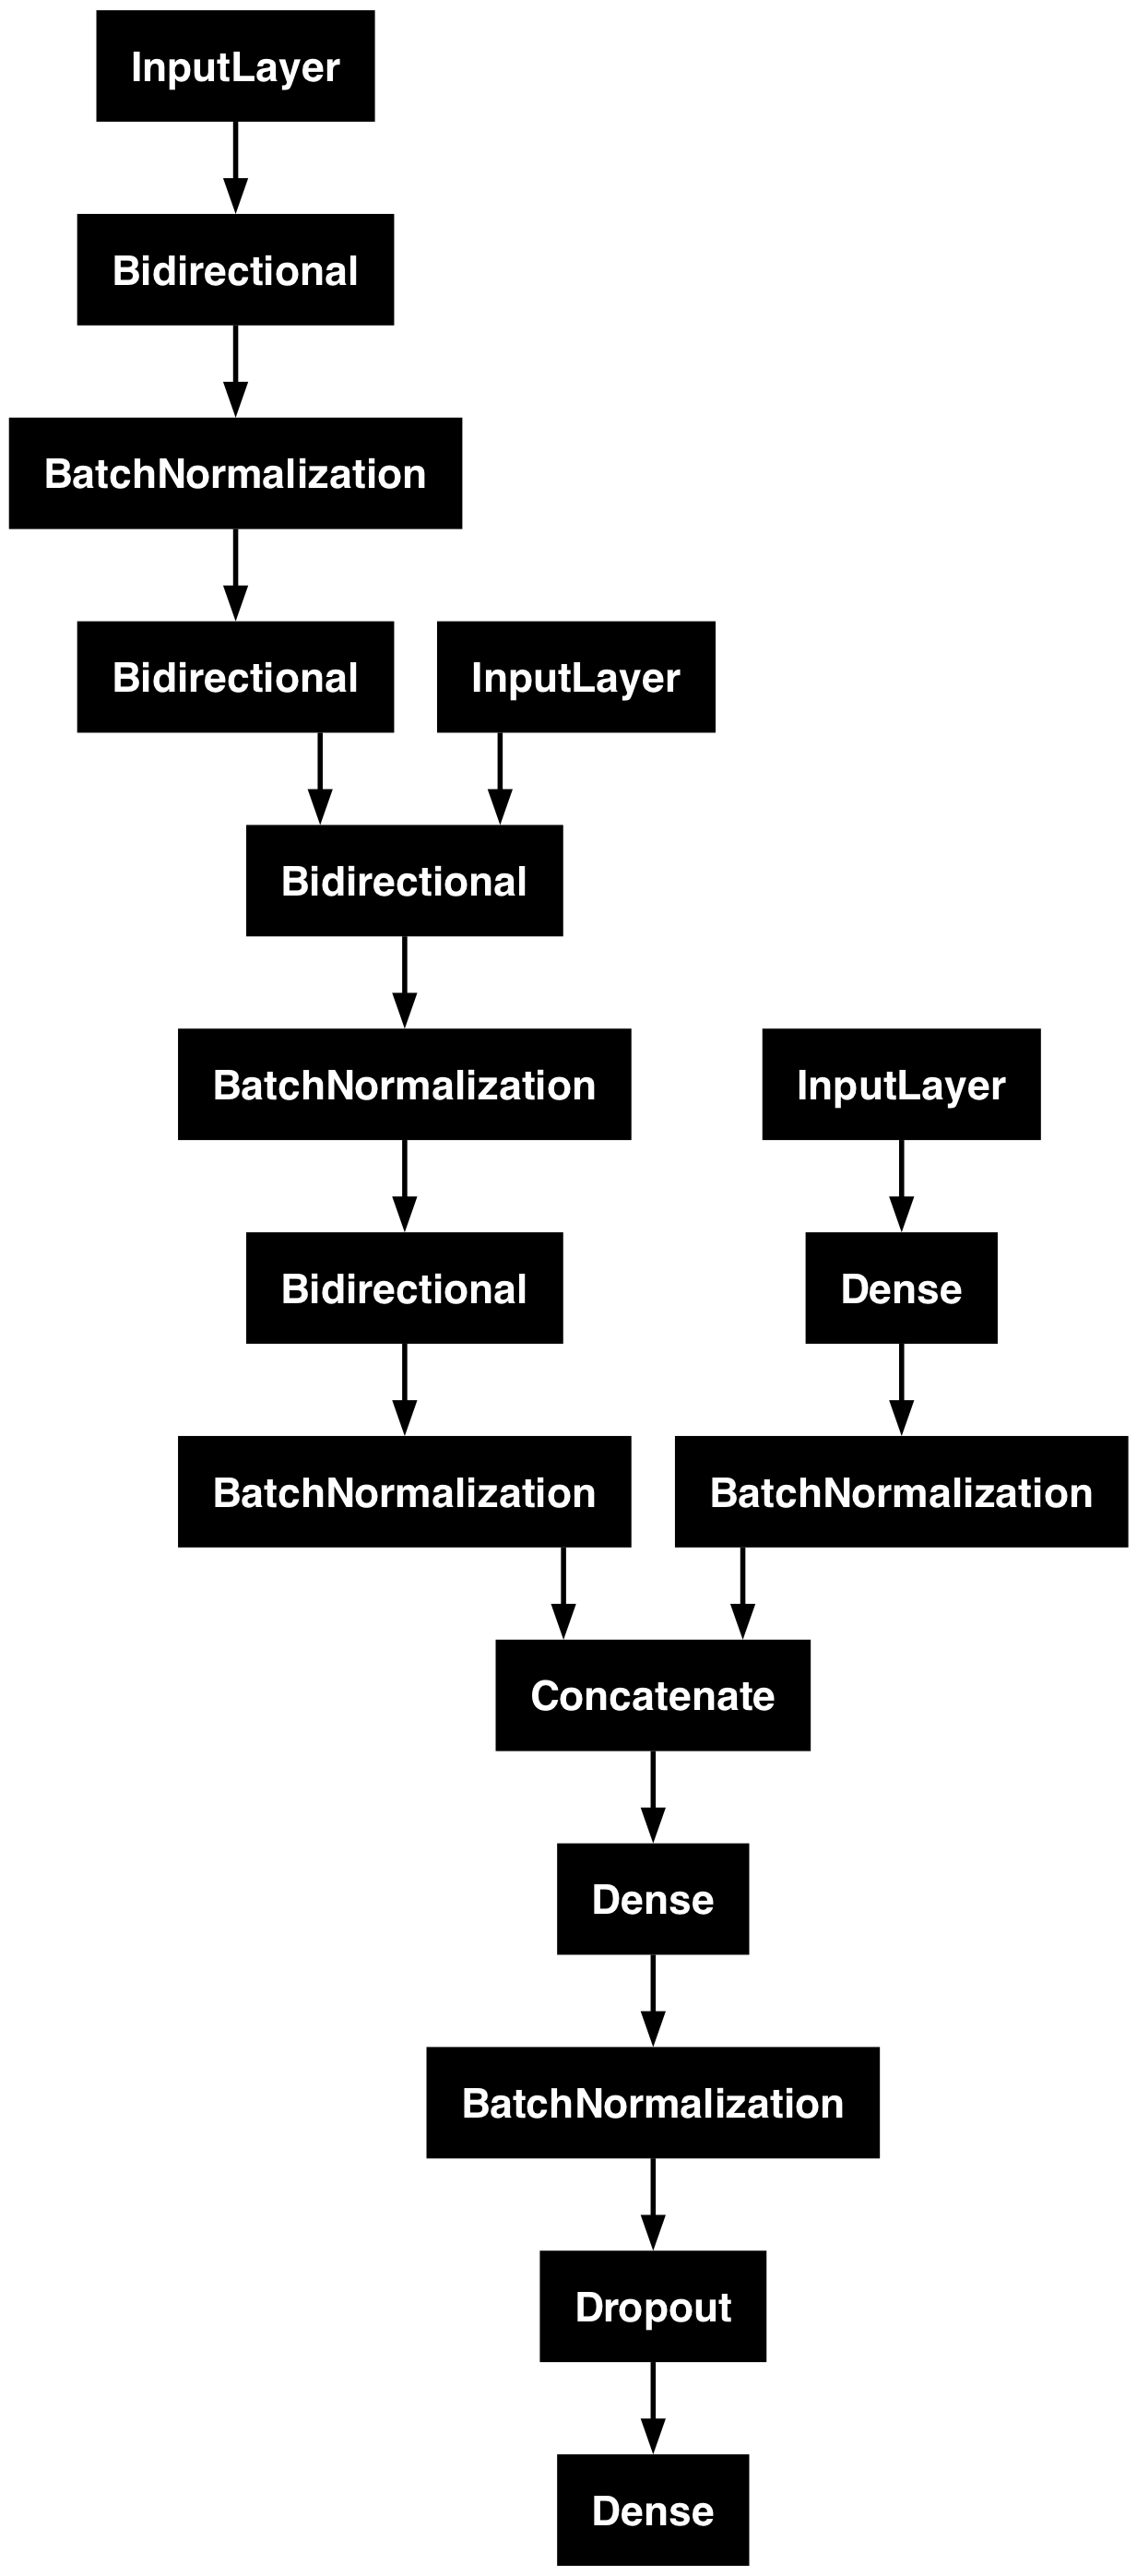

In [259]:
# Plot model architecture

from tensorflow.keras.utils import plot_model

# Group LSTM layers with their corresponding Dropout layers using nested blocks in the plot
plot_model(
    model2,
    to_file='rnn_model.png',
    show_shapes=False,
    show_layer_names=False,
    expand_nested=True
)

In [260]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# # Preprocessing
# # For TS part (records '0', '1', ... '99') extract seasonality, trend, residuals

# def decompose_ts(row):
#     ts = row[ts_columns].values
#     # Fill missing values if any
#     ts = pd.Series(ts).fillna(method='ffill').fillna(method='bfill')
#     # Decompose (period can be tuned, here set to 12 for example)
#     result = seasonal_decompose(ts, model='additive', period=12, extrapolate_trend='freq')
#     return pd.Series({
#         'trend': result.trend.values,
#         'seasonal': result.seasonal.values,
#         'residual': result.resid.values
#     })

# # Apply decomposition to train_df
# train_decomp = train_df.apply(decompose_ts, axis=1)
# val_decomp = val_df.apply(decompose_ts, axis=1)
# test_decomp = test_df.apply(decompose_ts, axis=1)

In [261]:
# train_decomp.head()

In [262]:
# # Standard scale the components
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# train_trend_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['trend'].tolist()))
# train_seasonal_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['seasonal'].tolist()))
# train_residual_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['residual'].tolist()))

# train_merge = pd.DataFrame({
#     'trend': list(train_trend_scaled),
#     'seasonal': list(train_seasonal_scaled),
#     'residual': list(train_residual_scaled)
# })

# val_trend_scaled = scaler.transform(pd.DataFrame(val_decomp['trend'].tolist()))
# val_seasonal_scaled = scaler.transform(pd.DataFrame(val_decomp['seasonal'].tolist()))
# val_residual_scaled = scaler.transform(pd.DataFrame(val_decomp['residual'].tolist()))

# val_merge = pd.DataFrame({
#     'trend': list(val_trend_scaled),
#     'seasonal': list(val_seasonal_scaled),
#     'residual': list(val_residual_scaled)
# })


# test_trend_scaled = scaler.transform(pd.DataFrame(test_decomp['trend'].tolist()))
# test_seasonal_scaled = scaler.transform(pd.DataFrame(test_decomp['seasonal'].tolist()))
# test_residual_scaled = scaler.transform(pd.DataFrame(test_decomp['residual'].tolist()))

# test_merge = pd.DataFrame({
#     'trend': list(test_trend_scaled),
#     'seasonal': list(test_seasonal_scaled),
#     'residual': list(test_residual_scaled)
# })

In [263]:
# # Build a RNN model using Keras
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Add
# from tensorflow.keras.utils import to_categorical
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.optimizers import Adam

# # Encode labels
# label_encoder = LabelEncoder()
# y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
# y_val_enc = to_categorical(label_encoder.transform(y_val))
# y_test_enc = to_categorical(label_encoder.transform(y_test))

# # Define model
# def build_rnn_model(residuals_shape, seasonality_shape, trend_shape, num_classes):
#     # Residuals component
#     inputs_residuals = Input(shape=residuals_shape)
#     x = LSTM(64, return_sequences=False)(inputs_residuals)
#     # x = LSTM(32, return_sequences=True)(x)
#     # x = Dropout(0.2)(x)
#     # x = LSTM(16, return_sequences=False)(x)
#     x = Dropout(0.2)(x)
#     residuals_output = Dense(8, activation='relu')(x)
    
#     # Seasonality component
#     inputs_seasonal = Input(shape=seasonality_shape)
#     y = LSTM(64, return_sequences=False)(inputs_seasonal)
#     # y = LSTM(32, return_sequences=True)(y)
#     # y = Dropout(0.2)(y)
#     # y = LSTM(16, return_sequences=False)(y)
#     y = Dropout(0.2)(y)
#     seasonal_output = Dense(8, activation='relu')(y)
    
#     # Trend component
#     inputs_trend = Input(shape=trend_shape)
#     z = LSTM(64, return_sequences=False)(inputs_trend)
#     # z = LSTM(32, return_sequences=True)(z)
#     # z = Dropout(0.2)(z)
#     # z = LSTM(16, return_sequences=False)(z)
#     z = Dropout(0.2)(z)
#     trend_output = Dense(8, activation='relu')(z)
    
    
#     # Combine all components using the functional API's Add layer
#     combined_tensor = Add()([residuals_output, seasonal_output, trend_output])
#     # Final dense layers for classification
#     d = Dense(16, activation='relu')(combined_tensor)
#     d = Dropout(0.3)(d)
#     d = Dense(32, activation='relu')(d)
#     d = Dropout(0.3)(d)
#     d = Dense(16, activation='relu')(d)
#     d = Dropout(0.3)(d)
    
#     outputs = Dense(num_classes, activation='softmax')(d)
    
#     model = Model(inputs=[inputs_residuals, inputs_seasonal, inputs_trend], outputs=outputs)
#     model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

In [264]:
# model = build_rnn_model(
#     residuals_shape=(100, 1),
#     seasonality_shape=(100, 1),
#     trend_shape=(100, 1),
#     num_classes=y_train_enc.shape[1]
# )
# model.summary()

In [265]:
# from sklearn.utils.class_weight import compute_class_weight

# weights = compute_class_weight(
#     class_weight="balanced",
#     classes=np.unique(y_train),
#     y=y_train
# )

# weights = dict(enumerate(weights))

# # Train the model
# history = model.fit(
#     [train_residual_scaled.reshape(-1, 100, 1),
#      train_seasonal_scaled.reshape(-1, 100, 1),
#      train_trend_scaled.reshape(-1, 100, 1)],
#     y_train_enc,
#     validation_data=(
#         [val_residual_scaled.reshape(-1, 100, 1),
#          val_seasonal_scaled.reshape(-1, 100, 1),
#          val_trend_scaled.reshape(-1, 100, 1)],
#         y_val_enc
#     ),
#     class_weight=weights,
#     epochs=50,
#     batch_size=32,
#     verbose=1,
# )

# # Evaluate the model
# test_loss, test_accuracy = model.evaluate(
#     [test_residual_scaled.reshape(-1, 100, 1),
#      test_seasonal_scaled.reshape(-1, 100, 1),
#      test_trend_scaled.reshape(-1, 100, 1)],
#     y_test_enc,
#     verbose=0
# )
# print(f'Test Accuracy: {test_accuracy:.4f}')

In [266]:
# # Plot training & validation accuracy values
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.grid(linestyle='--', alpha=0.6)
# # Plot training & validation loss values
# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')

# plt.grid(linestyle='--', alpha=0.6)
# plt.show()

In [267]:
# # classification report
# from sklearn.metrics import classification_report, confusion_matrix

# y_pred_probs = model.predict(
#     [test_residual_scaled.reshape(-1, 100, 1),
#      test_seasonal_scaled.reshape(-1, 100, 1),
#      test_trend_scaled.reshape(-1, 100, 1)]
# )
# y_pred = label_encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))
# print(classification_report(y_test, y_pred))

In [268]:
# import seaborn as sns
# cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
# plt.figure(figsize=(5, 5))
# sns.heatmap(cm, annot=True, fmt='d',
#             xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Reds', cbar=False)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion Matrix')
# plt.show()

In [269]:
# # Plot ROC curves for each class

# from sklearn.metrics import roc_curve, auc
# from sklearn.preprocessing import label_binarize
# y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
# n_classes = y_test_binarized.shape[1]
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
# # Plot all ROC curves
# plt.figure(figsize=(6, 5))
# colors = ['blue', 'green', 'red', 'orange']
# for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label='ROC curve of class {0} (area = {1:0.2f})'
#              ''.format(label_encoder.classes_[i], roc_auc[i]))
# plt.plot([0, 1], [0, 1], 'k--', lw=2)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curves')
# plt.legend(loc="lower right")
# plt.grid(linestyle='--', alpha=0.6)
# plt.show()